# Notebook 4: Persistence & Memory

## Learning Objectives
- Understand checkpointing in LangGraph
- Add conversation memory with `MemorySaver`
- Implement multi-turn conversations with thread IDs
- Resume from checkpoints

## Why Persistence?

Without persistence, every graph invocation starts fresh. Persistence enables:
- **Conversation history**: Remember previous messages
- **Long-running tasks**: Resume interrupted workflows
- **Human-in-the-loop**: Pause for approval, then continue
- **Debugging**: Inspect state at any point

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-5-mini", temperature=0.7)

## The Problem: Stateless Conversations

Without memory, the chatbot doesn't remember previous messages.

In [2]:
# Stateless chatbot (no memory)
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: ChatState) -> dict:
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

builder = StateGraph(ChatState)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

stateless_graph = builder.compile()

# Conversation 1
response1 = stateless_graph.invoke({"messages": [HumanMessage(content="My name is Alice.")]})
print("Response 1:", response1["messages"][-1].content)

# Conversation 2 - new invocation, no memory of previous
response2 = stateless_graph.invoke({"messages": [HumanMessage(content="What's my name?")]})
print("Response 2:", response2["messages"][-1].content)

Response 1: Nice to meet you, Alice. How can I help you today?
Response 2: I don't know— I don't have access to your personal info unless you tell me. What should I call you? (If you want, tell me a name or nickname and I'll use it for this conversation.)


## Adding Memory with MemorySaver

The `MemorySaver` checkpointer stores state in memory between invocations.

In [3]:
# Create a memory-based checkpointer
memory = MemorySaver()

# Rebuild the graph with checkpointer
builder = StateGraph(ChatState)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Compile WITH the checkpointer
stateful_graph = builder.compile(checkpointer=memory)

print("Graph compiled with memory!")

Graph compiled with memory!


## Thread IDs: Separating Conversations

Use `thread_id` in the config to maintain separate conversation threads.

In [4]:
# Conversation with Alice - Thread 1
config_alice = {"configurable": {"thread_id": "alice-conversation"}}

response1 = stateful_graph.invoke(
    {"messages": [HumanMessage(content="Hello! My name is Alice.")]},
    config=config_alice
)
print("Alice Turn 1:", response1["messages"][-1].content)

# Continue the same conversation
response2 = stateful_graph.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    config=config_alice
)
print("Alice Turn 2:", response2["messages"][-1].content)

Alice Turn 1: Hi Alice — nice to meet you! How can I help today? (Feel free to ask a question, tell me a task, or say what you want to chat about.)
Alice Turn 2: Your name is Alice.


In [5]:
# Different conversation with Bob - Thread 2
config_bob = {"configurable": {"thread_id": "bob-conversation"}}

response1 = stateful_graph.invoke(
    {"messages": [HumanMessage(content="Hi, I'm Bob!")]},
    config=config_bob
)
print("Bob Turn 1:", response1["messages"][-1].content)

response2 = stateful_graph.invoke(
    {"messages": [HumanMessage(content="What's my name?")]},
    config=config_bob
)
print("Bob Turn 2:", response2["messages"][-1].content)

Bob Turn 1: Hi Bob — nice to meet you! How can I help today? (Feel free to tell me what you want — info, writing/editing, coding, planning, brainstorming, or something else.)
Bob Turn 2: You said your name is Bob. Would you like me to call you Bob or something else?


In [6]:
# Go back to Alice's conversation - it remembers!
response3 = stateful_graph.invoke(
    {"messages": [HumanMessage(content="Can you remind me what my name is again?")]},
    config=config_alice
)
print("Alice Turn 3:", response3["messages"][-1].content)

Alice Turn 3: Your name is Alice.


## Inspecting State

You can inspect the current state of any thread.

In [8]:
# Get current state for Alice's thread
state = stateful_graph.get_state(config_alice)

print("Current state for Alice's thread:")
print(f"Number of messages: {len(state.values['messages'])}")
print("\nMessages:")
for msg in state.values['messages']:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  {role}: {msg.content[:80]}..." if len(msg.content) > 80 else f"  {role}: {msg.content}")

Current state for Alice's thread:
Number of messages: 6

Messages:
  Human: Hello! My name is Alice.
  AI: Hi Alice — nice to meet you! How can I help today? (Feel free to ask a question,...
  Human: What's my name?
  AI: Your name is Alice.
  Human: Can you remind me what my name is again?
  AI: Your name is Alice.


## State History & Time Travel

LangGraph keeps a history of states, allowing you to "time travel" to any previous point.

In [7]:
# Get state history
print("State history for Alice's thread:\n")

for i, state in enumerate(stateful_graph.get_state_history(config_alice)):
    print(f"Checkpoint {i}:")
    print(f"  Config: {state.config}")
    print(f"  Messages: {len(state.values['messages'])}")
    if state.values['messages']:
        last_msg = state.values['messages'][-1]
        print(f"  Last message: {last_msg.content[:50]}...")
    print()

State history for Alice's thread:

Checkpoint 0:
  Config: {'configurable': {'thread_id': 'alice-conversation', 'checkpoint_ns': '', 'checkpoint_id': '1f1075e0-f1cf-689c-8007-d2910b35228b'}}
  Messages: 6
  Last message: Your name is Alice....

Checkpoint 1:
  Config: {'configurable': {'thread_id': 'alice-conversation', 'checkpoint_ns': '', 'checkpoint_id': '1f1075e0-e206-6168-8006-d3115363e775'}}
  Messages: 5
  Last message: Can you remind me what my name is again?...

Checkpoint 2:
  Config: {'configurable': {'thread_id': 'alice-conversation', 'checkpoint_ns': '', 'checkpoint_id': '1f1075e0-e202-6b6c-8005-3f9e61b048ca'}}
  Messages: 4
  Last message: Your name is Alice....

Checkpoint 3:
  Config: {'configurable': {'thread_id': 'alice-conversation', 'checkpoint_ns': '', 'checkpoint_id': '1f1075df-a16b-62f8-8004-a1cc490ced3d'}}
  Messages: 4
  Last message: Your name is Alice....

Checkpoint 4:
  Config: {'configurable': {'thread_id': 'alice-conversation', 'checkpoint_ns': '', 'check

## Practical Example: Customer Support Bot with Memory

Let's build a more complete example with tools and memory.

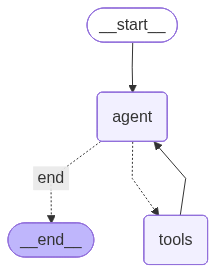

In [9]:
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

# Customer database (simulated)
CUSTOMERS = {
    "alice@email.com": {"name": "Alice Smith", "plan": "Premium", "balance": 150.00},
    "bob@email.com": {"name": "Bob Jones", "plan": "Basic", "balance": 0.00},
}

@tool
def lookup_customer(email: str) -> str:
    """Look up customer information by email.
    
    Args:
        email: Customer email address
    """
    if email in CUSTOMERS:
        c = CUSTOMERS[email]
        return f"Customer: {c['name']}, Plan: {c['plan']}, Balance: ${c['balance']:.2f}"
    return "Customer not found."

@tool
def update_plan(email: str, new_plan: str) -> str:
    """Update a customer's subscription plan.
    
    Args:
        email: Customer email address
        new_plan: New plan name (Basic, Premium, Enterprise)
    """
    if email in CUSTOMERS:
        old_plan = CUSTOMERS[email]["plan"]
        CUSTOMERS[email]["plan"] = new_plan
        return f"Updated {email} from {old_plan} to {new_plan}"
    return "Customer not found."

tools = [lookup_customer, update_plan]
llm_with_tools = llm.bind_tools(tools)

class SupportState(TypedDict):
    messages: Annotated[list, add_messages]

def support_agent(state: SupportState) -> dict:
    messages = [
        SystemMessage(content="""You are a helpful customer support agent. 
        You can look up customer information and update their plans.
        Always be polite and helpful."""),
        *state["messages"]
    ]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: SupportState) -> Literal["tools", "end"]:
    if state["messages"][-1].tool_calls:
        return "tools"
    return "end"

# Build graph
builder = StateGraph(SupportState)
builder.add_node("agent", support_agent)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
builder.add_edge("tools", "agent")

# Compile with memory
support_memory = MemorySaver()
support_graph = builder.compile(checkpointer=support_memory)

display(Image(support_graph.get_graph().draw_mermaid_png()))

In [10]:
# Simulate a multi-turn support conversation
config = {"configurable": {"thread_id": "support-session-1"}}

# Turn 1: Identify customer
print("=== Turn 1 ===")
response = support_graph.invoke(
    {"messages": [HumanMessage(content="Hi, I'm Alice. My email is alice@email.com")]},
    config=config
)
print(f"Agent: {response['messages'][-1].content}\n")

# Turn 2: Ask about account
print("=== Turn 2 ===")
response = support_graph.invoke(
    {"messages": [HumanMessage(content="Can you look up my account?")]},
    config=config
)
print(f"Agent: {response['messages'][-1].content}\n")

# Turn 3: Request change
print("=== Turn 3 ===")
response = support_graph.invoke(
    {"messages": [HumanMessage(content="I'd like to upgrade to Enterprise please.")]},
    config=config
)
print(f"Agent: {response['messages'][-1].content}\n")

# Turn 4: Verify change
print("=== Turn 4 ===")
response = support_graph.invoke(
    {"messages": [HumanMessage(content="Can you confirm my new plan?")]},
    config=config
)
print(f"Agent: {response['messages'][-1].content}")

=== Turn 1 ===
Agent: Hi Alice — I found your account.

Account summary
- Name: Alice Smith
- Email: alice@email.com
- Current plan: Premium
- Balance: $150.00

How can I help you today? I can:
- Change your plan (upgrade to Enterprise or downgrade to Basic)
- View or send recent invoices
- Update payment method or apply a payment
- Cancel or pause your subscription
- Help with usage, features, or billing questions

Tell me which action you’d like me to take. If you want a plan change, tell me which plan (Basic, Premium, or Enterprise) and I’ll proceed after your confirmation.

=== Turn 2 ===
Agent: Yes — I already looked up your account.

Account summary
- Name: Alice Smith
- Email: alice@email.com
- Current plan: Premium
- Balance: $150.00

Would you like me to do anything else (change plan, view/send invoices, update payment method, cancel/pause subscription, etc.)? If you want a plan change, tell me which plan and I’ll confirm before making it.

=== Turn 3 ===
Agent: All set — I up

## Production Considerations

For production, use persistent storage instead of in-memory:

```python
# SQLite (included with LangGraph)
from langgraph.checkpoint.sqlite import SqliteSaver
checkpointer = SqliteSaver.from_conn_string(":memory:")  # or "path/to/db.sqlite"

# PostgreSQL
from langgraph.checkpoint.postgres import PostgresSaver
checkpointer = PostgresSaver.from_conn_string("postgresql://...")
```

---

## Exercise 4: Build a Personal Assistant with Memory

Create a personal assistant that:
1. Remembers user preferences (stored in state)
2. Has tools to set/get preferences
3. Uses memory to maintain conversation context

Example conversation:
- User: "My favorite color is blue"
- User: "What's my favorite color?" → Should remember!
- User: "Set my timezone to EST"
- User: "What time is it?" → Should use timezone

In [13]:
# YOUR CODE HERE

# We'll store preferences in a simple dict (in production, use a database)
user_preferences = {}

class AssistantState(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def set_preference(key: str, value: str) -> str:
    """Set a user preference.
    
    Args:
        key: Preference name (e.g., 'color', 'timezone')
        value: Preference value
    """
    # TODO: Store the preference in user_preferences dict
    # TODO: Return confirmation message
    pass

@tool
def get_preference(key: str) -> str:
    """Get a user preference.
    
    Args:
        key: Preference name to retrieve
    """
    # TODO: Retrieve the preference from user_preferences dict
    # TODO: Return the value or "not set" message
    pass

@tool
def get_current_time(timezone: str = "UTC") -> str:
    """Get current time in a timezone.
    
    Args:
        timezone: Timezone name (e.g., 'UTC', 'EST', 'PST')
    """
    # TODO: Return current time (can use datetime.now())
    pass

# TODO: Create assistant_tools list with the 3 tools
# TODO: Bind tools to llm
# TODO: Create assistant_node function
# TODO: Create should_use_tools routing function
# TODO: Build the graph with StateGraph
# TODO: Compile with MemorySaver

# Test:
# config = {"configurable": {"thread_id": "user-123"}}
# result = assistant.invoke({"messages": [HumanMessage(content="My favorite color is blue")]}, config=config)
# result = assistant.invoke({"messages": [HumanMessage(content="What's my favorite color?")]}, config=config)

Got it — I've saved your favorite color as blue.
Your favorite color is blue.
Done — I set your timezone to EST.
It's 4:49 PM EST.


### Exercise 4: Solution (hidden)

<details>
<summary>Click to reveal solution</summary>

```python
# Store preferences in a simple dict (in production, use a database)
user_preferences = {}

class AssistantState(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def set_preference(key: str, value: str) -> str:
    """Set a user preference."""
    user_preferences[key] = value
    return f"Set {key} = {value}"

@tool
def get_preference(key: str) -> str:
    """Get a user preference."""
    if key in user_preferences:
        return f"{key} = {user_preferences[key]}"
    return f"No preference set for {key}"

@tool
def get_current_time(timezone: str = "UTC") -> str:
    """Get current time in a timezone."""
    from datetime import datetime
    return f"Current time ({timezone}): {datetime.now().strftime('%H:%M')}"

assistant_tools = [set_preference, get_preference, get_current_time]
assistant_llm = llm.bind_tools(assistant_tools)

def assistant_node(state: AssistantState) -> dict:
    messages = [
        SystemMessage(content="You are a helpful personal assistant. Use tools to manage user preferences."),
        *state["messages"]
    ]
    return {"messages": [assistant_llm.invoke(messages)]}

def should_use_tools(state: AssistantState) -> str:
    if state["messages"][-1].tool_calls:
        return "tools"
    return "end"

builder = StateGraph(AssistantState)
builder.add_node("assistant", assistant_node)
builder.add_node("tools", ToolNode(assistant_tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", should_use_tools, {"tools": "tools", "end": END})
builder.add_edge("tools", "assistant")

assistant = builder.compile(checkpointer=MemorySaver())

# Test it:
config = {"configurable": {"thread_id": "user-123"}}

result = assistant.invoke(
    {"messages": [HumanMessage(content="My favorite color is blue")]}, 
    config=config
)
print(result["messages"][-1].content)

result = assistant.invoke(
    {"messages": [HumanMessage(content="What's my favorite color?")]}, 
    config=config
)
print(result["messages"][-1].content)
```
</details>

## Key Takeaways

1. **MemorySaver** provides in-memory checkpointing
2. **thread_id** separates different conversation threads
3. Use **get_state()** and **get_state_history()** to inspect state
4. For production, use **SqliteSaver** or **PostgresSaver**
5. Memory enables natural multi-turn conversations

## Next: Multi-Agent Orchestration

In the final notebook, we'll learn how to orchestrate multiple agents working together!